In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

import matplotlib.backends.backend_pdf

import geopandas as gpd

import matplotlib as mpl

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.patches as mpatches

# Vehicle-specific cartographic summary maps. LSFF.

In [2]:
## load legal combos
import pickle
data_prep_dir = '/ihme/homes/beatrixh/notebooks/viv_rsc/data_prep/inputs/'

with open(data_prep_dir + 'lsff_vehicle_nutrient_pairs.pickle', 'rb') as handle:
    vehicle_nutrient_map = pickle.load(handle)
    
with open(data_prep_dir + 'lsff_country_vehicle_pairs.pickle', 'rb') as handle:
    country_vehicle_map = pickle.load(handle)
    
with open(data_prep_dir + 'lsff_vehicle_country_pairs.pickle', 'rb') as handle:
    vehicle_country_map = pickle.load(handle)

In [3]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world.name = world.name.astype(str)

world.loc[world.name=="Dem. Rep. Congo",'name'] = 'Democratic Republic of the Congo'
world.loc[world.name=="Tanzania",'name'] = 'United Republic of Tanzania'
world = world.rename(columns={'name':'location_name'})

In [4]:
path = '/ihme/homes/beatrixh/notebooks/viv_rsc/data_prep/outputs/lsff_data_estimated.csv'
df = pd.read_csv(path)

In [5]:
df['A_estimate'] = [0 if pd.notna(a) else np.nan for a in df.A]

In [6]:
vehicle = 'oil'

In [7]:
df['completeness'] = sum([df.A.notna(),df.B.notna(),df.C.notna()]) #a 3 means we have all data, 0 means none
df['count_estimated'] = df[['A_estimate','B_estimate','C_estimate']].sum(axis=1) #a 3 means all datapoints estimated, 0 means none

#nutrient-weighted
df['nw_completeness'] = df.groupby(['location_name','vehicle']).transform('mean').completeness

#max completeness by nutrient
df['max_completeness'] = df.groupby(['location_name','vehicle']).transform('max').completeness

In [8]:
df['color_var'] = [5 if nw==3.0 else #all nutrients complete
                   4 if mc==3.0 else #at least one nutrient (max) complete
                   3 if mc==2.0 else #at least one nutrient (max) has 2 datapoints
                   2 if mc==1.0 else #at least one nutrient (max) has 1 datapoint
                   1                   #no data 
                   for (nw,mc) in zip(df.nw_completeness,df.max_completeness)]

In [9]:
#make sure that this successfully mapped one color_var per loc/vehicle
assert(df.loc[df.vehicle==vehicle,['location_name','color_var']].drop_duplicates().shape[0]==df.location_name.nunique())

In [10]:
plot_df = df.groupby(['location_name','vehicle','color_var'], as_index = False).sum()

In [11]:
plot_df['texture_var'] = [1 if i > 0 else 0 for i in plot_df.count_estimated]

In [12]:
plot_df = world[['location_name','geometry']].merge(plot_df, on = 'location_name', how = 'right')

In [13]:
assert(plot_df[plot_df.vehicle==vehicle].shape[0]==plot_df[plot_df.vehicle==vehicle].location_name.nunique())

In [14]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [18]:
mystic = np.array([[232/256, 236/256, 241/256, 1]])

greenblue4 = np.array([[23/256, 75/256, 84/256, 1]]) 
green3 = np.array([[7/256, 110/256, 57/256, 1]])
green3 = np.array([[52/256, 99/256, 39/256, 1]])
green2 = np.array([[123/256, 178/256, 108/256, 1]])
yellow1 = np.array([[216/256, 191/256, 70/256, .8]])
pink = np.array([[250/256, 122/256, 179/256, 1]]) #zero color\
# pink = np.array([[223/256, 103/256, 138/256, 1]])
pink = np.array([[246/256, 90/256, 108/256, 1]])

usecolors = ListedColormap(np.concatenate([pink, yellow1, green2, greenblue4]))
usecolors_mystic = ListedColormap(np.concatenate([mystic, pink, yellow1, green2, greenblue4]))

In [16]:
df['color_var'] = [4 if nw==3.0 else #all nutrients complete
                   3 if mc==3.0 else #at least one nutrient (max) complete
                   2 if (mc==2.0 or mc==1.0) else #at least one nutrient (max) has 1-2 datapoints
                   1                   #no data 
                   for (nw,mc) in zip(df.nw_completeness,df.max_completeness)]

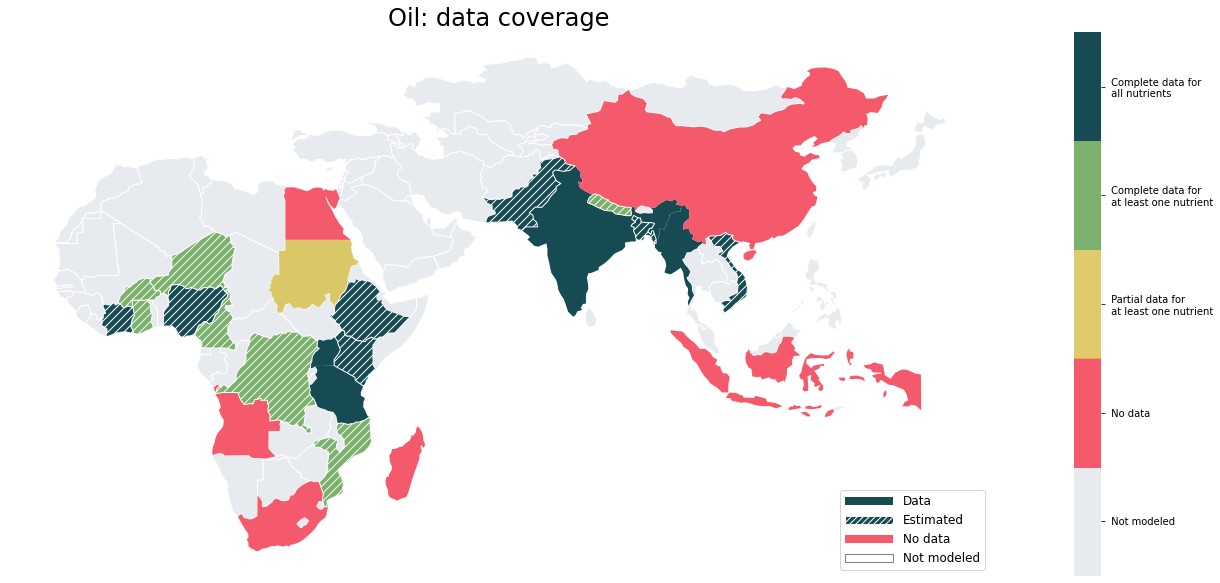

In [38]:
vehicle='oil'

# initialize plot
fig, ax = plt.subplots(figsize=(30,10))
ax.set_aspect('equal')
ax.set_title(f'{vehicle.capitalize()}: data coverage', fontsize = 24)
ax.set_axis_off()

# all country outlines
mystic_tuple = (232/256, 236/256, 241/256, 1)
base = world[world.continent.isin(['Africa','Asia'])].plot(ax=ax, color=mystic_tuple, edgecolor='white')

# cmap = plt.cm.get_cmap('copper_r', df.color_var.nunique())
# main = plot_df[(plot_df.vehicle==vehicle) & (plot_df.texture_var==0)].plot(ax = base,
#                                       cmap = usecolors,
#                                       column='color_var')
# main = plot_df[(plot_df.vehicle==vehicle) & (plot_df.texture_var==1)].plot(ax = base,
#                                       cmap = usecolors,
#                                       column='color_var')

norm = mpl.colors.BoundaryNorm(ticks, usecolors_mystic.N)
main = plot_df[(plot_df.vehicle==vehicle)].plot(ax = base,
                                      cmap = usecolors,
                                      column='color_var')

main = plot_df[(plot_df.vehicle==vehicle) &
               (plot_df.texture_var==1)].plot(ax = base,
                                              norm=norm,
                                              cmap = usecolors,
                                              column='color_var',
                                              hatch = '///',
                                              edgecolor='white')



ticks = np.arange(0,6,1.00001)
norm = mpl.colors.BoundaryNorm(ticks, usecolors_mystic.N)
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=usecolors_mystic),
                    ticks = [0,1,2],
                    ax=ax)

cbar.outline.set_visible(False)
cbar.set_ticks(ticks + 0.5)
cbar.ax.set_yticklabels([' Not modeled',
                         ' No data',
                         ' Partial data for\n at least one nutrient',
                         ' Complete data for\n at least one nutrient',
                         ' Complete data for\n all nutrients'])

## add legend for textures
greenblue4_tuple = (23/256, 75/256, 84/256, 1) #RGBA
pink_tuple = (246/256, 90/256, 108/256, 1)

have_data = mpatches.Patch(facecolor=greenblue4_tuple,label='Data')
estimated_data = mpatches.Patch(facecolor=greenblue4_tuple,hatch='////', edgecolor='white', label='Estimated')
unknown = mpatches.Patch(facecolor=pink_tuple, label='No data')
not_modeled = mpatches.Patch(facecolor='white', edgecolor = 'gray', label='Not modeled')

plt.legend(handles = [have_data,estimated_data,unknown,not_modeled], loc=4, fontsize=12, handlelength=4)


plt.show()

In [46]:
def output_map(df, vehicle):
    # initialize plot
    fig, ax = plt.subplots(figsize=(30,10))
    ax.set_aspect('equal')
    ax.set_title(f'{vehicle.capitalize()}: data coverage', fontsize = 24)
    ax.set_axis_off()

    # all country outlines
    mystic_tuple = (232/256, 236/256, 241/256, 1)
    base = world[world.continent.isin(['Africa','Asia'])].plot(ax=ax, color=mystic_tuple, edgecolor='white')

    # cmap = plt.cm.get_cmap('copper_r', df.color_var.nunique())
    # main = plot_df[(plot_df.vehicle==vehicle) & (plot_df.texture_var==0)].plot(ax = base,
    #                                       cmap = usecolors,
    #                                       column='color_var')
    # main = plot_df[(plot_df.vehicle==vehicle) & (plot_df.texture_var==1)].plot(ax = base,
    #                                       cmap = usecolors,
    #                                       column='color_var')
    
    ticks = np.arange(0,6,1.00001)
    norm = mpl.colors.BoundaryNorm(ticks, usecolors_mystic.N)
    main = plot_df[(plot_df.vehicle==vehicle)].plot(ax = base,
                                          cmap = usecolors,
                                          column='color_var')

    main = plot_df[(plot_df.vehicle==vehicle) &
                   (plot_df.texture_var==1)].plot(ax = base,
                                                  norm=norm,
                                                  cmap = usecolors,
                                                  column='color_var',
                                                  hatch = '///',
                                                  edgecolor='white')



    
    norm = mpl.colors.BoundaryNorm(ticks, usecolors_mystic.N)
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=usecolors_mystic),
                        ticks = [0,1,2],
                        ax=ax)

    cbar.outline.set_visible(False)
    cbar.set_ticks(ticks + 0.5)
    cbar.ax.set_yticklabels([' Not modeled',
                             ' No data',
                             ' Partial data for\n at least one nutrient',
                             ' Complete data for\n at least one nutrient',
                             ' Complete data for\n all nutrients'])
    
    ## add legend for textures
    greenblue4_tuple = (23/256, 75/256, 84/256, 1) #RGBA
    pink_tuple = (246/256, 90/256, 108/256, 1)

    have_data = mpatches.Patch(facecolor=greenblue4_tuple,label='Have data')
    estimated_data = mpatches.Patch(facecolor=greenblue4_tuple,hatch='////', edgecolor='white', label='Estimated data')
    unknown = mpatches.Patch(facecolor=pink_tuple, label='No data')
    not_modeled = mpatches.Patch(facecolor=mystic_tuple, edgecolor = 'white', label='Not modeled')

    plt.legend(handles = [have_data,estimated_data,unknown,not_modeled], loc=4, fontsize=12, handlelength=4)

    return fig

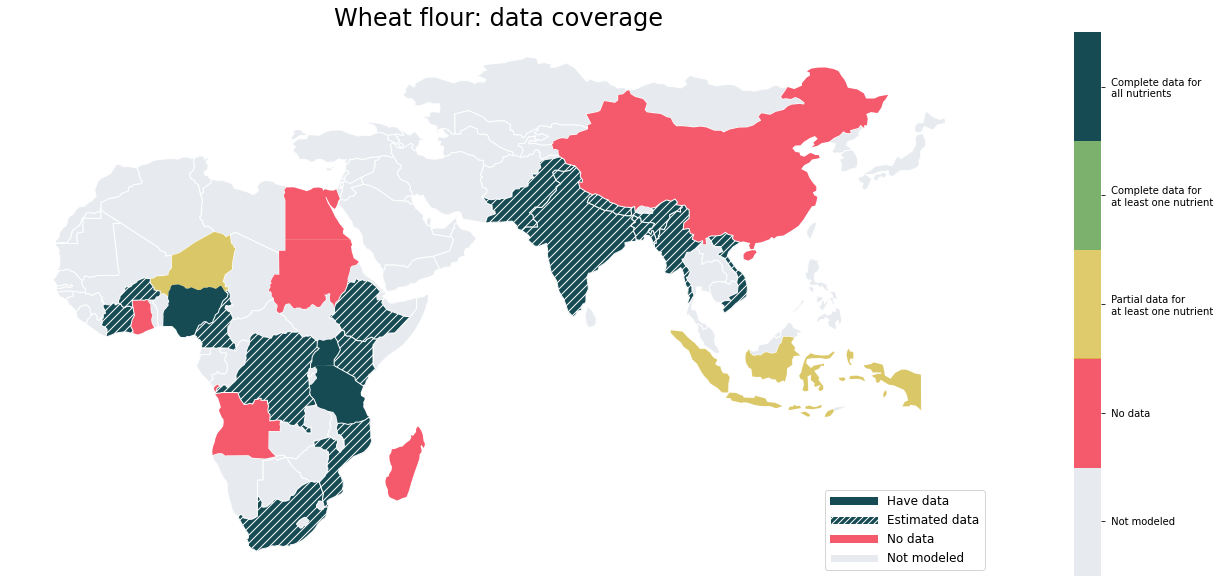

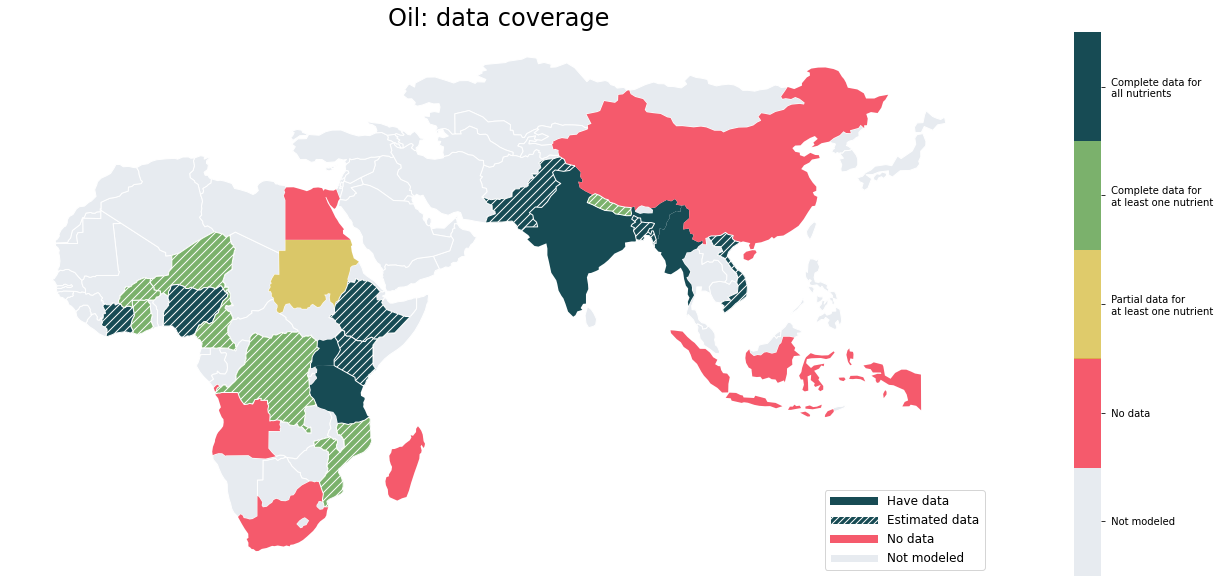

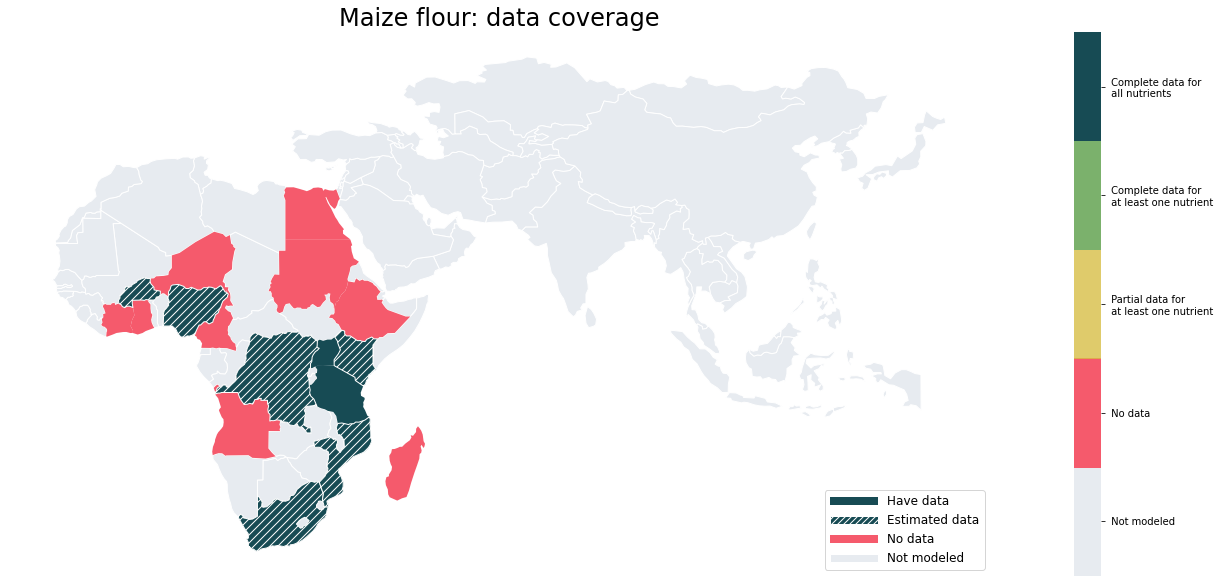

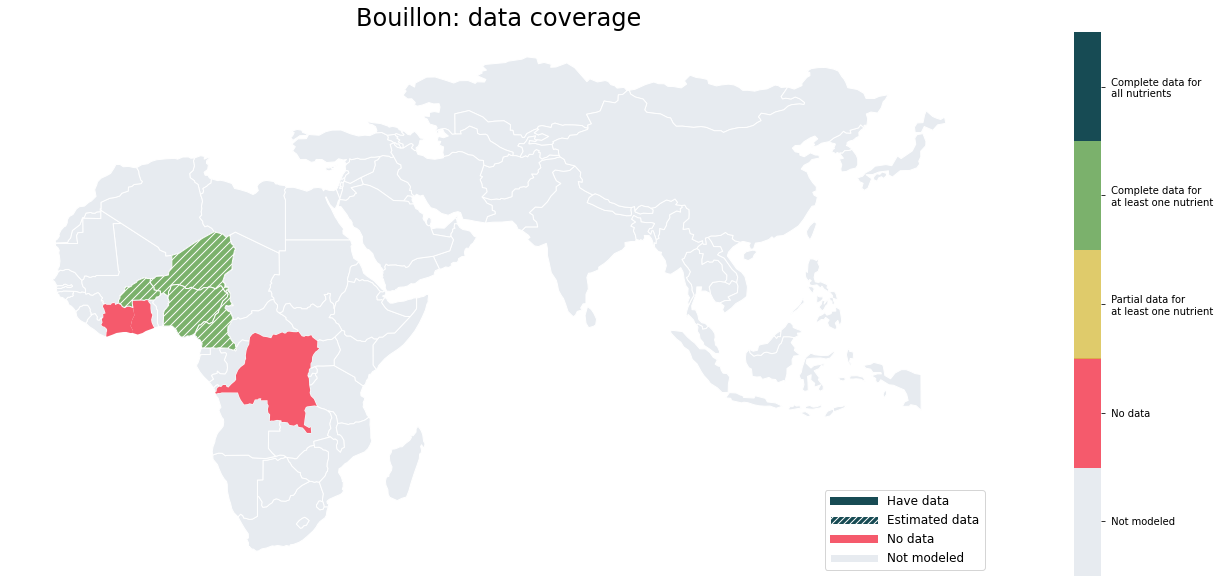

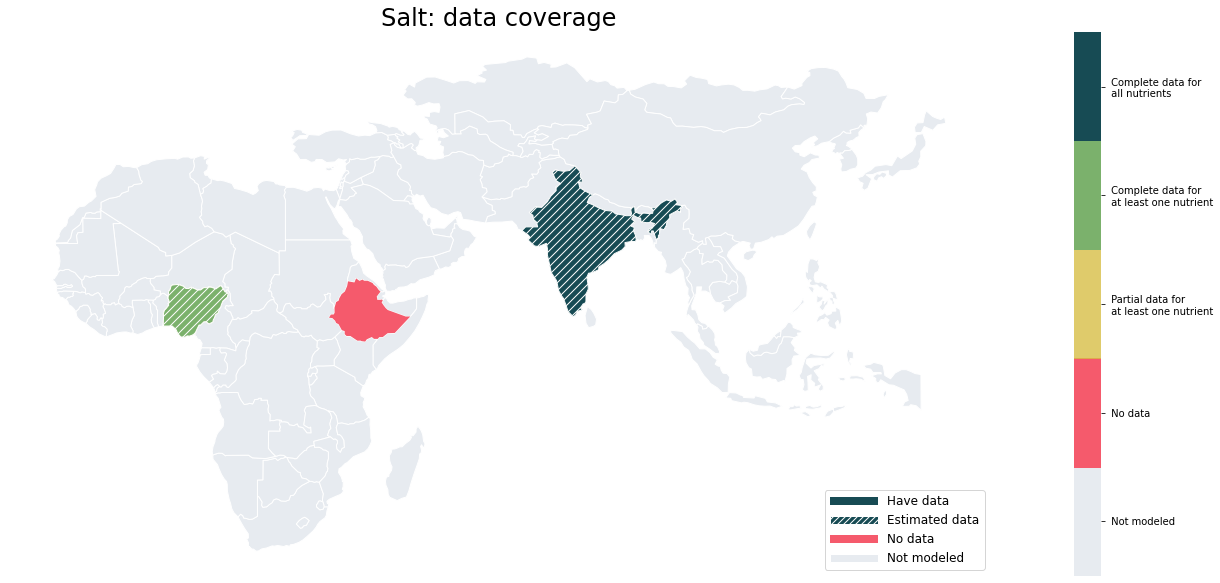

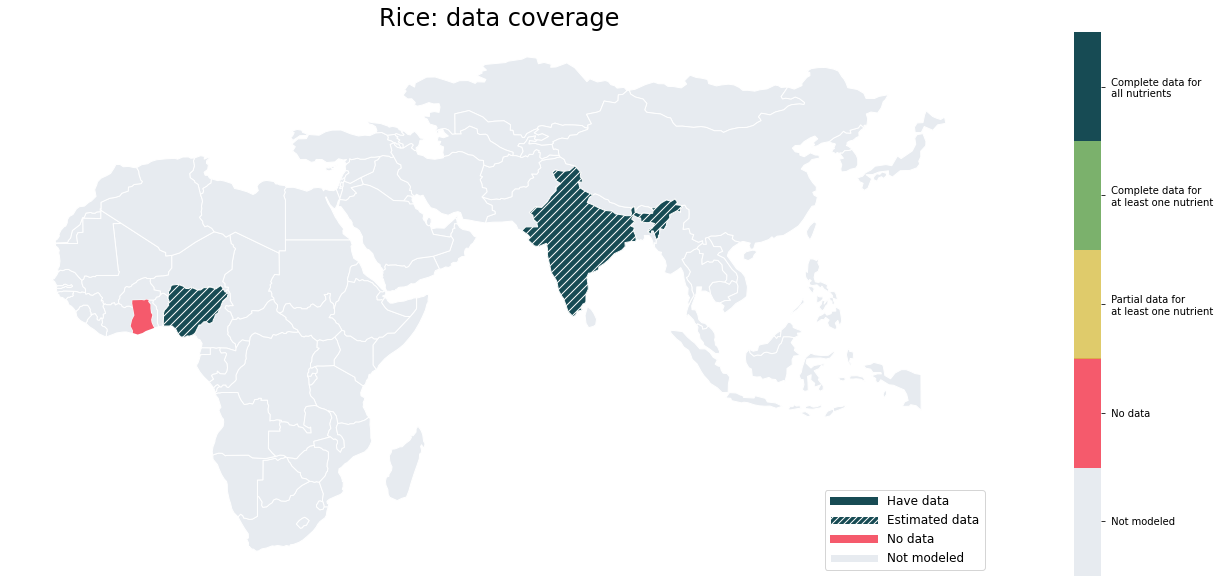

In [47]:
for vehicle in df.vehicle.unique():
    fig = output_map(plot_df, vehicle)